# Parte 1 - Coleta de dados

A FIDE não disponibiliza uma base de dados unificada com o rating dos jogadores ao longo dos anos. Por isso, essa primeira parte do notebook é para montar essa base.

Ao final desse processo, será gerado um arquivo `ratings.json`, contendo o top-100 de jogadores ao longo dos anos, com a seguinte estrutura:

```python
[
  {
    'date_human': 'January 2018',
    'year': 2018,
    'month': 'January',
    'ratings': [
      ['Carlsen, Magnus', 2834],
      ['Caruana, Fabiano', 2811],
      # ...
    ]
  },
  # ...
]
```

Essa etapa **não** precisa ser exucutada. O arquivo `ratings.json` já está disponível no repositório.

Esse código só está aqui para fins de histórico e pro caso de se querer estender a base de dados para anos anteriores a **2013** (quando a FIDE começou a disponibilizar o ranking 1x por mês).

In [1]:
# import json
# import requests
# from bs4 import BeautifulSoup

In [2]:
# URL_TEMPLATE = "https://ratings.fide.com/toparc.phtml?cod={{ cod }}"

# COD_START = 241 # jan-2013
# COD_END = 761 # nov-2023

# all_cods = []

# cod = COD_START
# while cod <= COD_END:
#     all_cods.append(cod)
#     cod += 4

# num_cods = len(all_cods)

# rankings = []

# for idx, cod in enumerate(all_cods):
#     url = URL_TEMPLATE.replace('{{ cod }}', str(cod))
#     print(f"Baixando ranking de {url} ({idx + 1} de {num_cods})")
#     r = requests.get(url)
#     if r.status_code != 200:
#         print(f"[ERROR] Erro ao baixar esse ranking. Status code: {r.status_code}")
#         continue

#     soup = BeautifulSoup(r.content, 'html.parser')

#     title = soup.title.text.split('Top 100 Players ')[1].split(' FIDE')[0]
#     year, month = title.split(' ')

#     ratings = []
#     table = soup.find(id='main-col').find_all('table')[1].find('table')
#     for row in table.find_all('tr'):
#         cols = row.find_all('td')
#         player_name = cols[1].text.strip()
#         if player_name == 'Name':
#             continue
#         rating = int(cols[4].text.strip())
#         ratings.append([player_name, rating])

#     rankings.append({
#         'date_human': title,
#         'year': year,
#         'month': int(month),
#         'ratings': ratings,
#     })
    
# with open('./ratings.json', 'w') as fp:
#     json.dump(rankings, fp)

# print('Fim!')

# Parte 2

Algumas análises comparando o rating do top-1 em relação aos demais jogadores, considerando:
- alguns percentis de rating desses jogadores;
- a média geral do rating desses jogadores;
- o rating do 2º jogador do ranking.

O objetivo aqui é entender o quão distante o top-1 estava em relação aos demais.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

In [4]:
ratings_df = pd.read_json('ratings.json')
ratings_df

,date_human,year,month,ratings
0,January 2013,January,2013,"[[Carlsen, Magnus, 2861], [Kramnik, Vladimir, ..."
1,February 2013,February,2013,"[[Carlsen, Magnus, 2872], [Kramnik, Vladimir, ..."
2,March 2013,March,2013,"[[Carlsen, Magnus, 2872], [Kramnik, Vladimir, ..."
3,April 2013,April,2013,"[[Carlsen, Magnus, 2872], [Aronian, Levon, 280..."
4,May 2013,May,2013,"[[Carlsen, Magnus, 2868], [Aronian, Levon, 281..."
...,...,...,...,...
126,July 2023,July,2023,"[[Carlsen, Magnus, 2835], [Nakamura, Hikaru, 2..."
127,August 2023,August,2023,"[[Carlsen, Magnus, 2835], [Nakamura, Hikaru, 2..."
128,September 2023,September,2023,"[[Carlsen, Magnus, 2839], [Caruana, Fabiano, 2..."
129,October 2023,October,2023,"[[Carlsen, Magnus, 2839], [Caruana, Fabiano, 2..."


In [5]:
data = []

for index, row in ratings_df.iterrows():
    all_ratings = [r[1] for r in row['ratings']]
    all_ratings = np.array(all_ratings)

    top_1_rating = all_ratings[0]
    top_2_rating = all_ratings[1]

    data.append({
        'date_human': row['date_human'],
        'p50': np.percentile(all_ratings, 50),
        'p75': np.percentile(all_ratings, 75),
        'p95': np.percentile(all_ratings, 95),
        'avg': np.average(all_ratings),
        'top_1': top_1_rating,
        'top_2': top_2_rating,
    })

df = pd.DataFrame(data)
df

,date_human,p50,p75,p95,avg,top_1,top_2
0,January 2013,2696.0,2722.75,2779.60,2701.696078,2861,2810
1,February 2013,2700.0,2722.00,2780.30,2703.390000,2872,2810
2,March 2013,2700.0,2722.75,2783.35,2702.823529,2872,2810
3,April 2013,2697.5,2718.25,2781.35,2700.346154,2872,2809
4,May 2013,2697.0,2720.00,2779.20,2702.230000,2868,2813
...,...,...,...,...,...,...,...
126,July 2023,2688.5,2719.25,2777.10,2695.570000,2835,2787
127,August 2023,2684.5,2717.00,2777.10,2694.280000,2835,2787
128,September 2023,2688.0,2717.50,2771.30,2694.000000,2839,2786
129,October 2023,2687.5,2716.25,2771.30,2693.630000,2839,2786


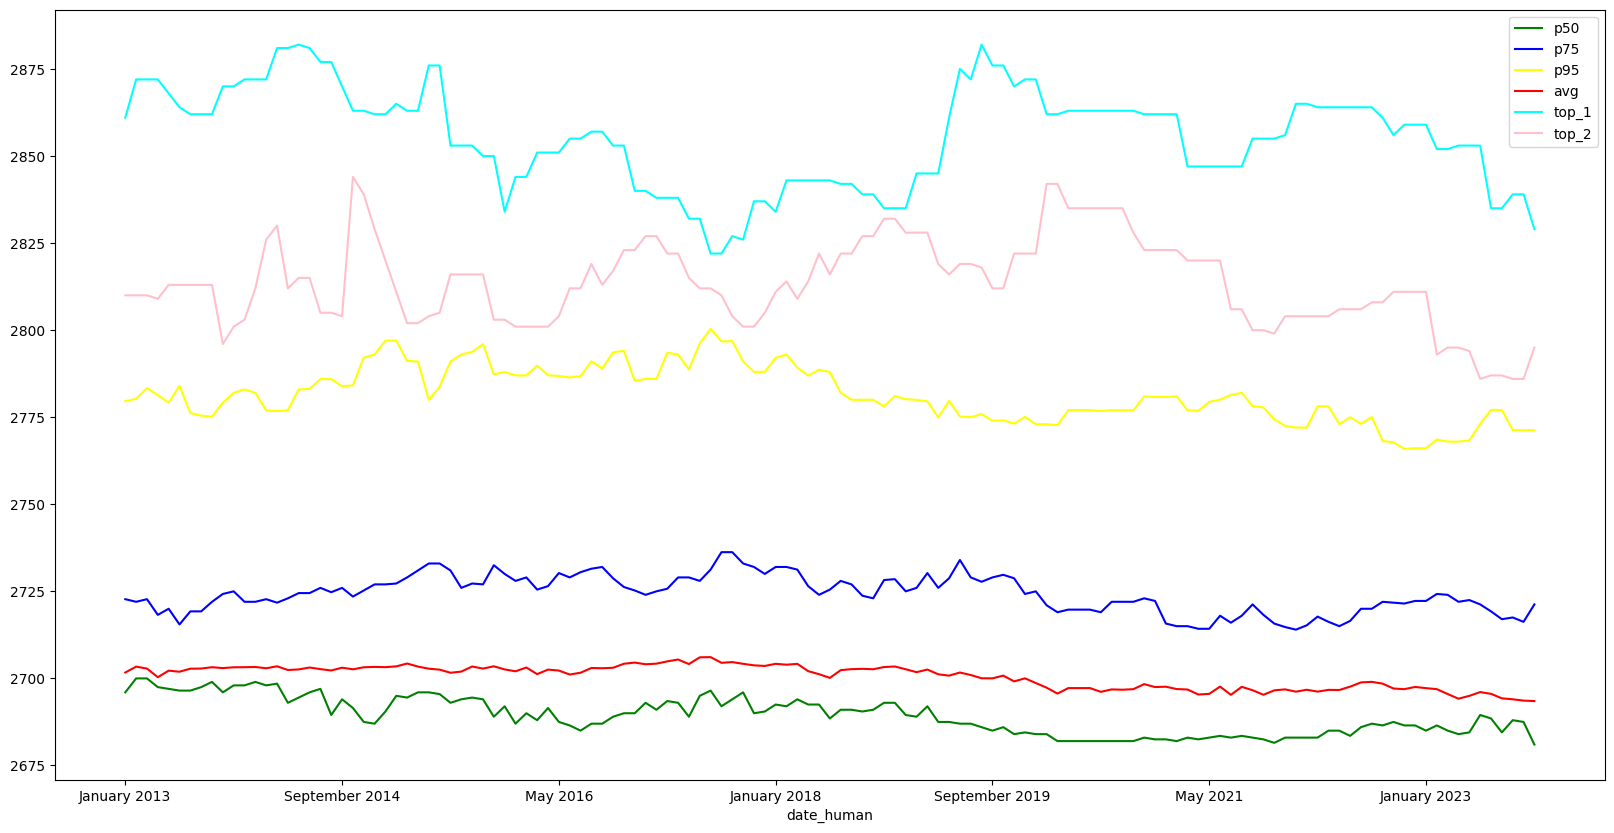

In [6]:
plt.rcParams['figure.figsize'] = [20, 10]

ax = plt.gca()
df.plot(kind='line', x='date_human', y='p50', color='green', ax=ax)
df.plot(kind='line', x='date_human', y='p75', color='blue', ax=ax)
df.plot(kind='line', x='date_human', y='p95', color='yellow', ax=ax)
df.plot(kind='line', x='date_human', y='avg', color='red', ax=ax)
df.plot(kind='line', x='date_human', y='top_1', color='cyan', ax=ax)
df.plot(kind='line', x='date_human', y='top_2', color='pink', ax=ax)
  
plt.show()

In [7]:
data = []

for index, row in ratings_df.iterrows():
    top_1_rating = row['ratings'][0][1]
    top_2_rating = row['ratings'][1][1]
    p50 = np.percentile(all_ratings, 50)
    p75 = np.percentile(all_ratings, 75)
    p95 = np.percentile(all_ratings, 95)

    data.append({
        'date_human': row['date_human'],
        'distance_top_1_2': (top_1_rating - top_2_rating),
        'distance_top_1_p50': (top_1_rating - p50),
        'distance_top_1_p75': (top_1_rating - p75),
        'distance_top_1_p95': (top_1_rating - p95),
    })

df = pd.DataFrame(data)
df

,date_human,distance_top_1_2,distance_top_1_p50,distance_top_1_p75,distance_top_1_p95
0,January 2013,51,180.0,139.75,89.7
1,February 2013,62,191.0,150.75,100.7
2,March 2013,62,191.0,150.75,100.7
3,April 2013,63,191.0,150.75,100.7
4,May 2013,55,187.0,146.75,96.7
...,...,...,...,...,...
126,July 2023,48,154.0,113.75,63.7
127,August 2023,48,154.0,113.75,63.7
128,September 2023,53,158.0,117.75,67.7
129,October 2023,53,158.0,117.75,67.7


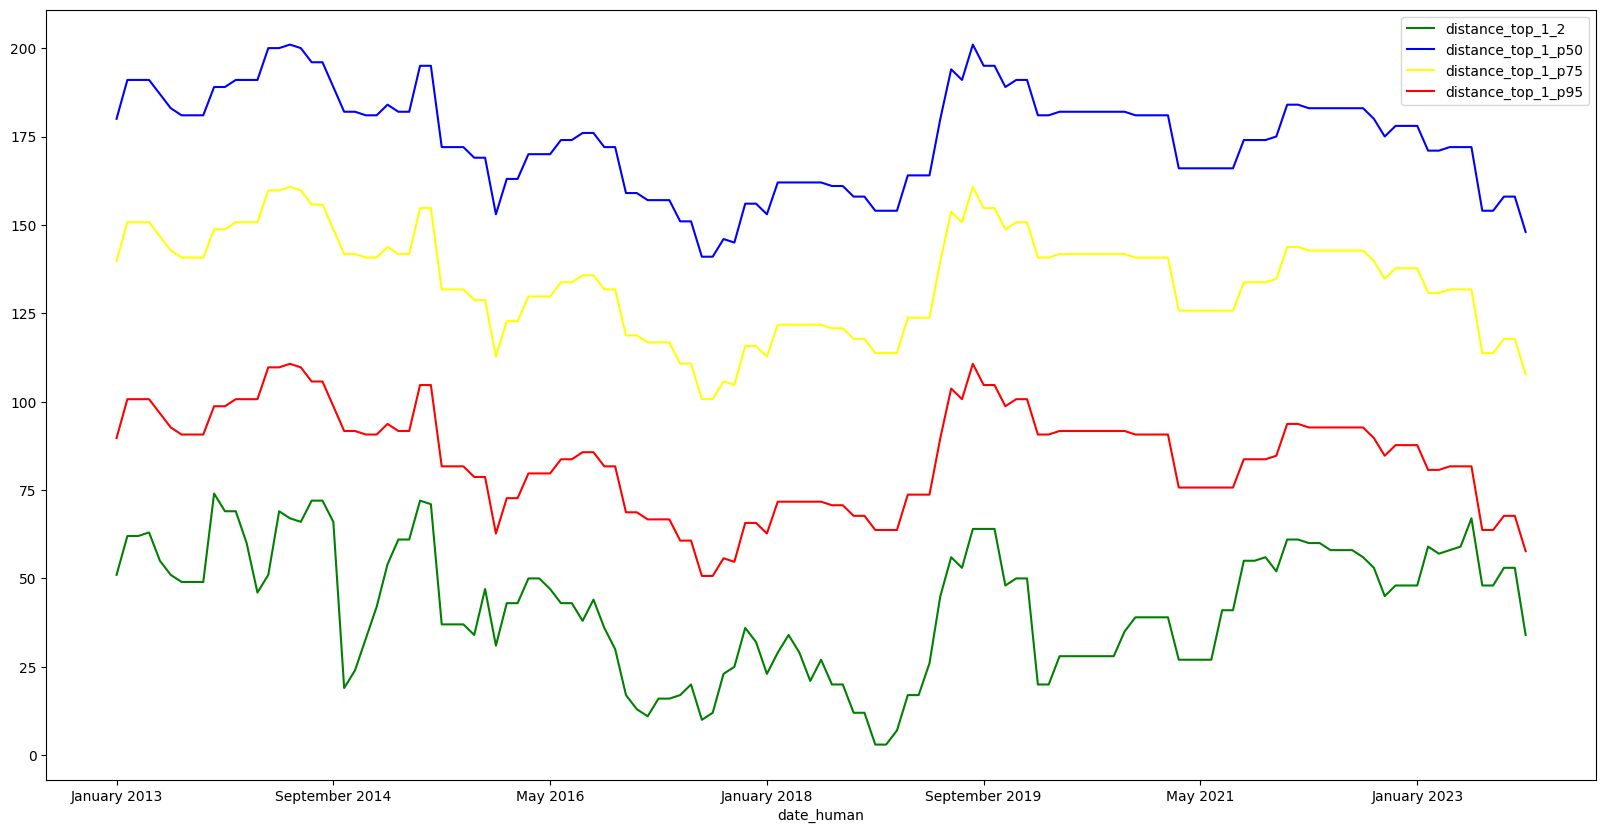

In [8]:
plt.rcParams['figure.figsize'] = [20, 10]

ax = plt.gca()
df.plot(kind='line', x='date_human', y='distance_top_1_2', color='green', ax=ax)
df.plot(kind='line', x='date_human', y='distance_top_1_p50', color='blue', ax=ax)
df.plot(kind='line', x='date_human', y='distance_top_1_p75', color='yellow', ax=ax)
df.plot(kind='line', x='date_human', y='distance_top_1_p95', color='red', ax=ax)

plt.show()

# Parte 3

As mesmas análises da parte 2, mas sem levar em conta o jogador top-1.

O objetivo aqui é retirar o ruído causado pelo Carlsen nos últimos anos, já que ele sempre esteve muito acima dos demais.

Ao fazer isso, conseguiremos ter uma ideia melhor de como está a briga entre os 99 jogadores restantes do top-100.

In [9]:
data = []

for index, row in ratings_df.iterrows():
    all_ratings = [r[1] for r in row['ratings']][1:]
    all_ratings = np.array(all_ratings)

    top_2_rating = all_ratings[0]
    top_3_rating = all_ratings[1]

    data.append({
        'date_human': row['date_human'],
        'p50': np.percentile(all_ratings, 50),
        'p75': np.percentile(all_ratings, 75),
        'p95': np.percentile(all_ratings, 95),
        'avg': np.average(all_ratings),
        'top_2': top_2_rating,
        'top_3': top_3_rating,
    })

df = pd.DataFrame(data)
df

,date_human,p50,p75,p95,avg,top_2,top_3
0,January 2013,2696.0,2722.0,2772.0,2700.118812,2810,2802
1,February 2013,2698.0,2722.0,2771.9,2701.686869,2810,2809
2,March 2013,2700.0,2722.0,2771.0,2701.148515,2810,2809
3,April 2013,2697.0,2714.5,2771.9,2698.679612,2809,2801
4,May 2013,2697.0,2718.5,2775.4,2700.555556,2813,2811
...,...,...,...,...,...,...,...
126,July 2023,2688.0,2719.0,2775.2,2694.161616,2787,2782
127,August 2023,2684.0,2713.5,2769.8,2692.858586,2787,2782
128,September 2023,2688.0,2716.5,2761.1,2692.535354,2786,2780
129,October 2023,2686.0,2716.0,2761.1,2692.161616,2786,2780


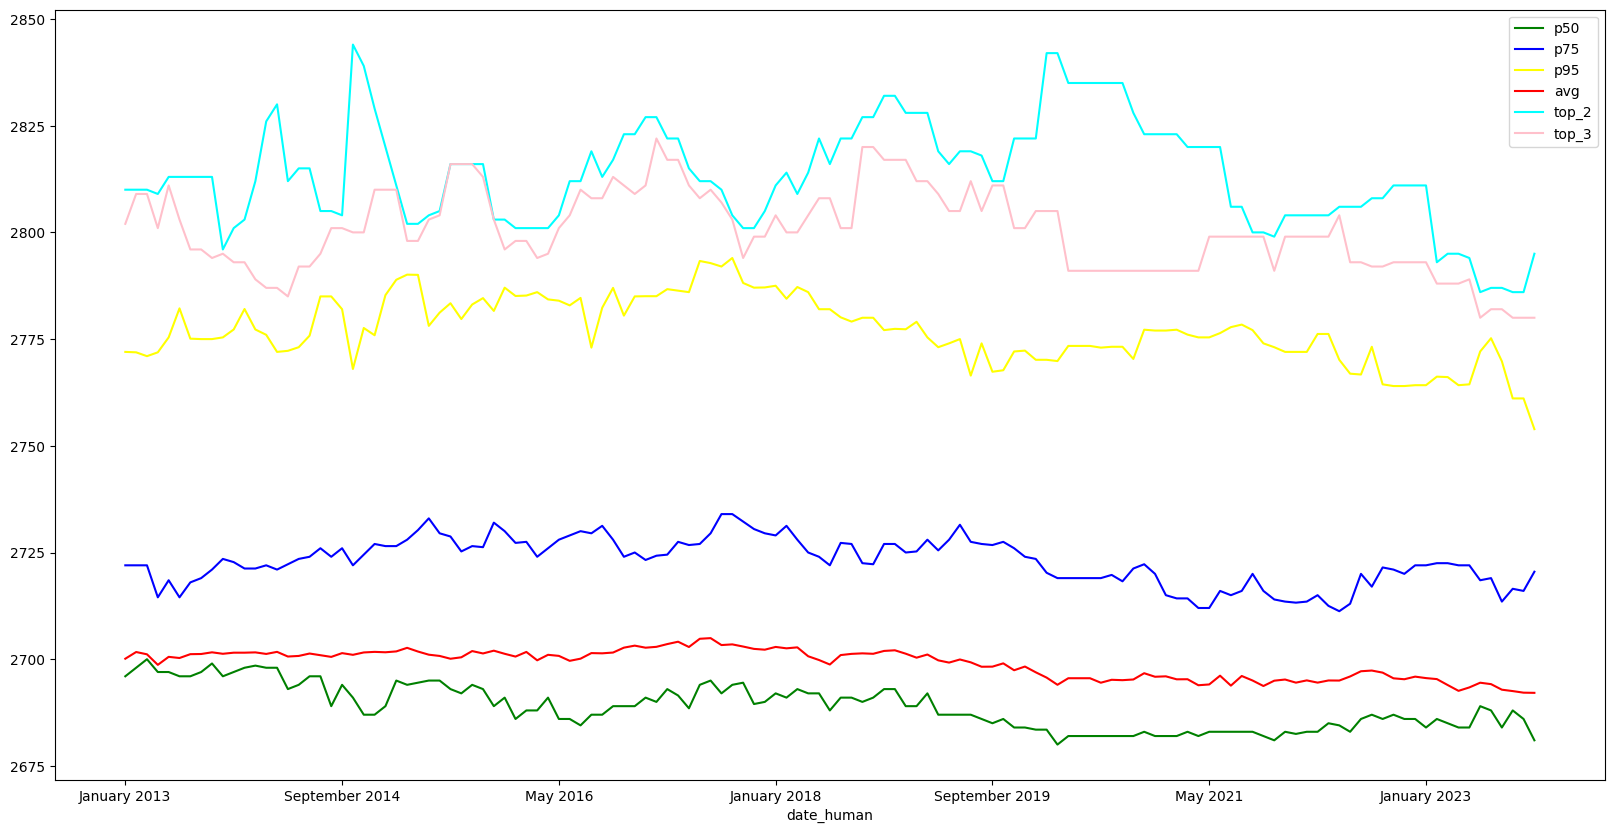

In [10]:
plt.rcParams['figure.figsize'] = [20, 10]

ax = plt.gca()
df.plot(kind='line', x='date_human', y='p50', color='green', ax=ax)
df.plot(kind='line', x='date_human', y='p75', color='blue', ax=ax)
df.plot(kind='line', x='date_human', y='p95', color='yellow', ax=ax)
df.plot(kind='line', x='date_human', y='avg', color='red', ax=ax)
df.plot(kind='line', x='date_human', y='top_2', color='cyan', ax=ax)
df.plot(kind='line', x='date_human', y='top_3', color='pink', ax=ax)
  
plt.show()

In [11]:
data = []

for index, row in ratings_df.iterrows():
    top_2_rating = row['ratings'][1][1]
    top_3_rating = row['ratings'][2][1]
    p50 = np.percentile(all_ratings, 50)
    p75 = np.percentile(all_ratings, 75)
    p95 = np.percentile(all_ratings, 95)

    data.append({
        'date_human': row['date_human'],
        'distance_top_2_3': (top_2_rating - top_3_rating),
        'distance_top_2_p50': (top_2_rating - p50),
        'distance_top_2_p75': (top_2_rating - p75),
        'distance_top_2_p95': (top_2_rating - p95),
    })

df = pd.DataFrame(data)
df

,date_human,distance_top_2_3,distance_top_2_p50,distance_top_2_p75,distance_top_2_p95
0,January 2013,8,129.0,89.5,56.1
1,February 2013,1,129.0,89.5,56.1
2,March 2013,1,129.0,89.5,56.1
3,April 2013,8,128.0,88.5,55.1
4,May 2013,2,132.0,92.5,59.1
...,...,...,...,...,...
126,July 2023,5,106.0,66.5,33.1
127,August 2023,5,106.0,66.5,33.1
128,September 2023,6,105.0,65.5,32.1
129,October 2023,6,105.0,65.5,32.1


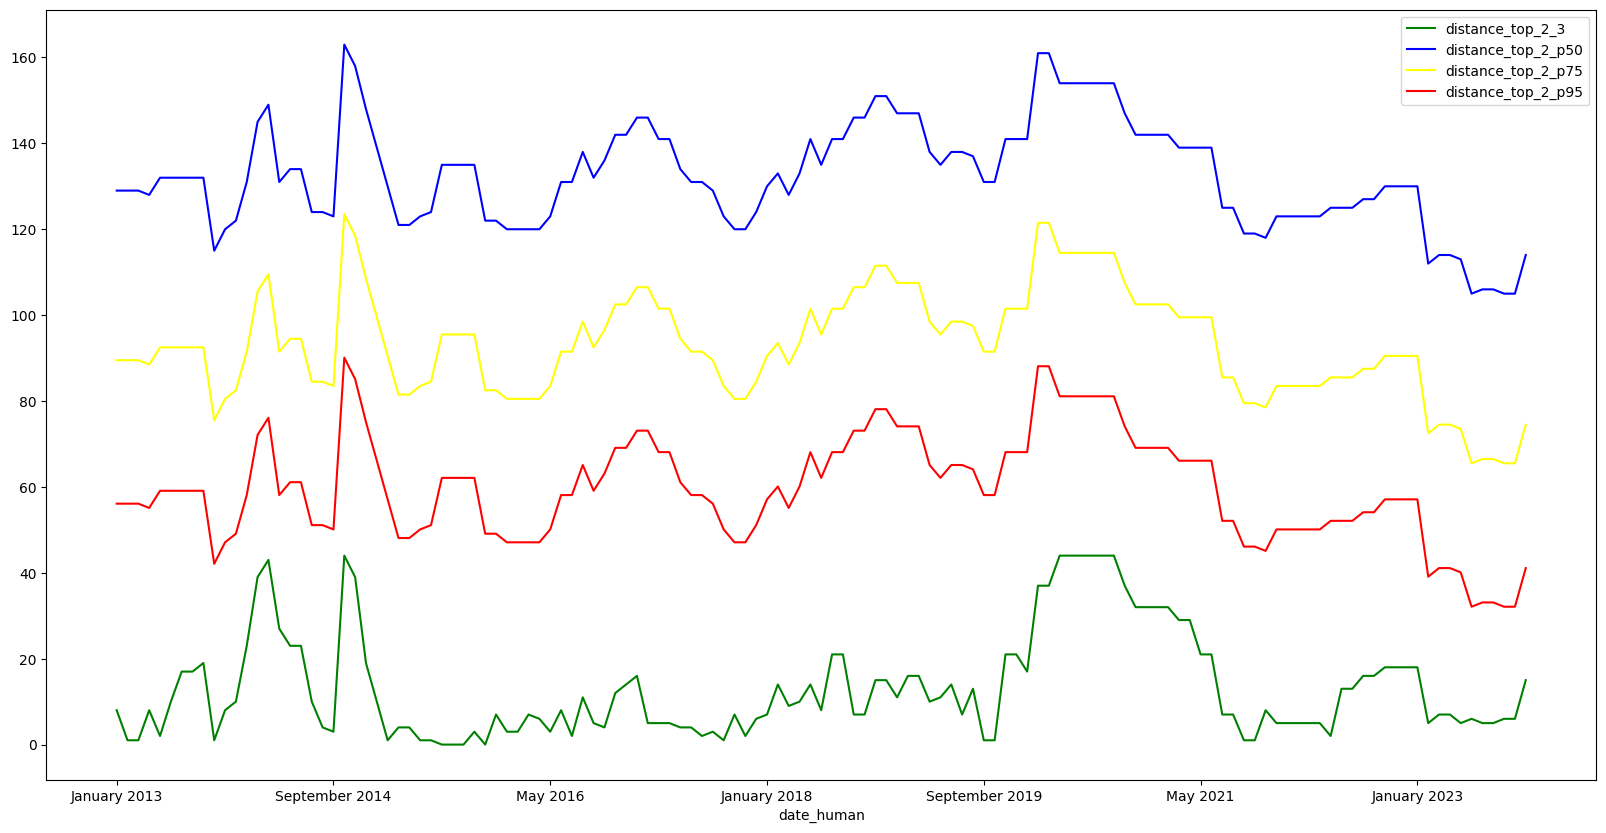

In [12]:
plt.rcParams['figure.figsize'] = [20, 10]

ax = plt.gca()
df.plot(kind='line', x='date_human', y='distance_top_2_3', color='green', ax=ax)
df.plot(kind='line', x='date_human', y='distance_top_2_p50', color='blue', ax=ax)
df.plot(kind='line', x='date_human', y='distance_top_2_p75', color='yellow', ax=ax)
df.plot(kind='line', x='date_human', y='distance_top_2_p95', color='red', ax=ax)

plt.show()